# Exercise 1:
- Select any two companies that are listed on the stock market
- Download daily data 2017-2023
- Create two datasets:
    - date -> datetime type
    - dates period: 2017-2023
- Get basic statistics, transform to stationar time series
- Make a summary

#### Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
FIGSIZE = (12,4)
SUB_FISIZE = (12,8)

from datetime import datetime

import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

Importing plotly failed. Interactive plots will not work.


#### Preparation Datasets

As an example we will consider TESLA and APPLE:
- https://www.nasdaq.com/market-activity/stocks/tsla/historical
- https://www.nasdaq.com/market-activity/stocks/aapl/historical


In [2]:
# column 'Date' -> datetime -> index
def preprocess_df(path):
    df = pd.read_csv(path, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df
    
# remove '$' from all df values
def remove_character(df, symbol: str):
    for column in df.columns.to_list():
        if df[column].dtypes == object:
            df[column] = df[column].apply(lambda x: x.replace(symbol, ''))

# all 'object' values -> 'float'
def to_float(df):
    for column in df.columns.to_list():
        if column != 'Date':
            df[column] =  df[column].astype(float)

In [3]:
df_tesla = preprocess_df('./tesla.csv')
remove_character(df_tesla, '$')
to_float(df_tesla)

df_apple = preprocess_df('./apple.csv')
remove_character(df_apple, '$')
to_float(df_apple)

In [4]:
print('Tesla:')
print(df_tesla.head(3))
print('-----------')
print('Apple:')
print(df_apple.head(3))

Tesla:
            Close/Last       Volume     Open     High      Low
Date                                                          
2013-09-30     12.8913  133849178.0  12.6000  12.9667  12.5333
2013-10-01     12.8667  116320352.0  12.9307  12.9487  12.5580
2013-10-02     12.0633  310766545.0  12.5727  12.7887  11.6933
-----------
Apple:
            Close/Last       Volume     Open     High      Low
Date                                                          
2013-09-30     17.0268  259059760.0  17.0446  17.2021  16.9433
2013-10-01     17.4271  352776899.0  17.0875  17.4693  17.0850
2013-10-02     17.4843  287196445.0  17.3439  17.5643  17.2768


Let's look at the closing price charts on the stock exchange by day (2017-2023):

<Axes: title={'center': 'TESLA'}, xlabel='Date'>

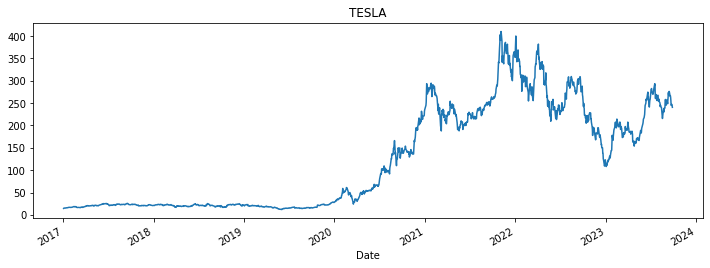

In [5]:
df_tesla.loc['2017-01-01':'2023-09-27']['Close/Last'].plot(figsize=FIGSIZE, title='TESLA')

<Axes: title={'center': 'TESLA'}, xlabel='Date'>

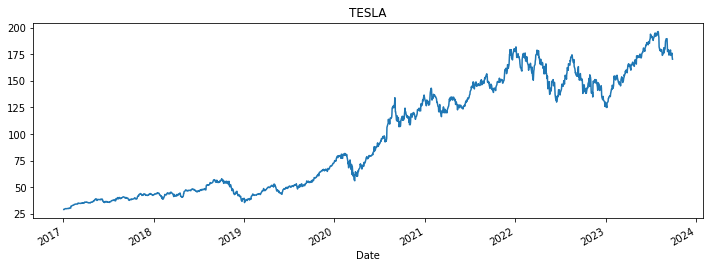

In [6]:
df_apple.loc['2017-01-01':'2023-09-27']['Close/Last'].plot(figsize=FIGSIZE, title='TESLA')

## Decomposition

Any time series can be decomposed into components:
- Trend
- Seasonality
- Residual

Let's do it with statsmodels:

In [7]:
# create datasets 2017-2023
df_tesla = df_tesla.loc['2017-01-03':'2023-09-27']['Close/Last']
df_apple = df_apple.loc['2017-01-01':'2023-09-27']['Close/Last']

In [8]:
# function to show original, trend, seasonal and residual plots
def show_decomposition(df, title):
    df_decomposed = seasonal_decompose(df, model='additive', period=30)
    plt.figure(figsize=SUB_FISIZE)
    plt.subplot(411)
    plt.plot(df_decomposed.observed, label='Observed')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(df_decomposed.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(df_decomposed.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(df_decomposed.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.suptitle(title, size=16)
    plt.show()

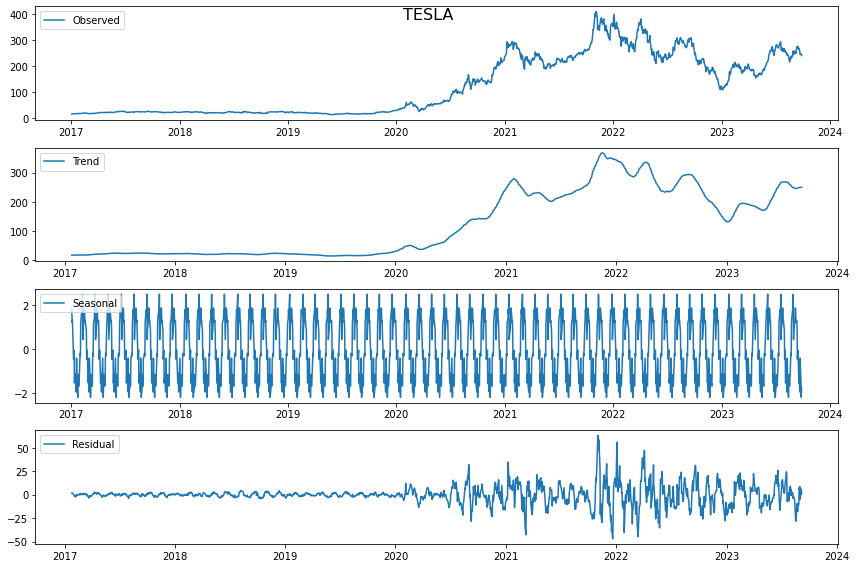

In [9]:
show_decomposition(df_tesla, 'TESLA')

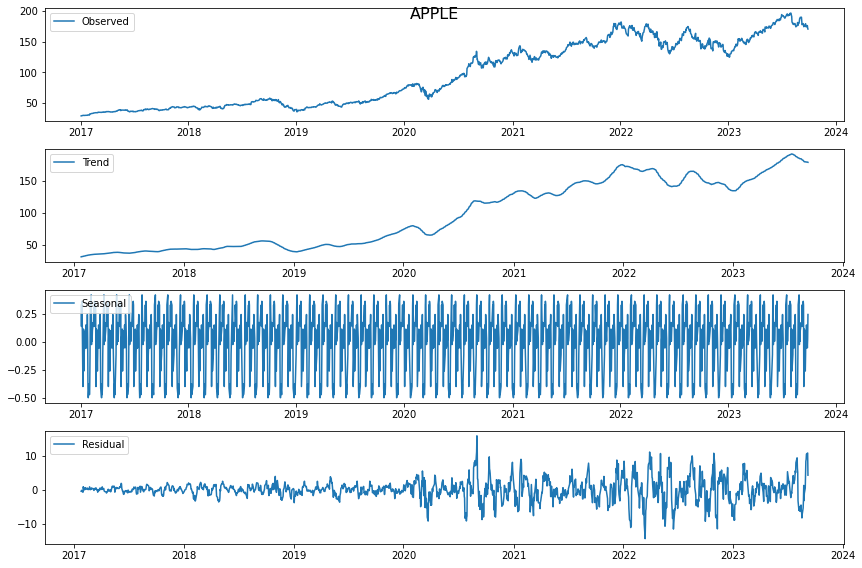

In [10]:
show_decomposition(df_apple, 'APPLE')

## Stationarity

Now let's try to bring our time series to stationary ones:

In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [12]:
# to determine stationarity we will use the test Augmented Dickey-Fuller unit root test
def test_stationarity(timeseries, main_title):
    print(f'Results of Dickey-Fuller Test ({main_title}):')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# function to show time series, autocorrelation and partitial autocorrelation
def tsplot(y, main_title, change, lags=100, figsize=SUB_FISIZE, style='bmh'):
    test_stationarity(y, main_title)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
   # with plt.style.context(style):
    plt.figure(figsize=SUB_FISIZE)
    layout = (4, 1)
    ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
    acf_ax = plt.subplot2grid(layout, (2, 0))
    pacf_ax = plt.subplot2grid(layout, (3, 0))

    y.plot(ax=ts_ax, label='Or')
    ts_ax.set_title(change)

    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

    plt.suptitle(main_title, size=16)
    plt.tight_layout()
    return

#### Without transformation:

Results of Dickey-Fuller Test (Tesla):
Test Statistic                   -1.290514
p-value                           0.633501
#Lags Used                       24.000000
Number of Observations Used    1670.000000
Critical Value (1%)              -3.434272
Critical Value (5%)              -2.863272
Critical Value (10%)             -2.567692
dtype: float64


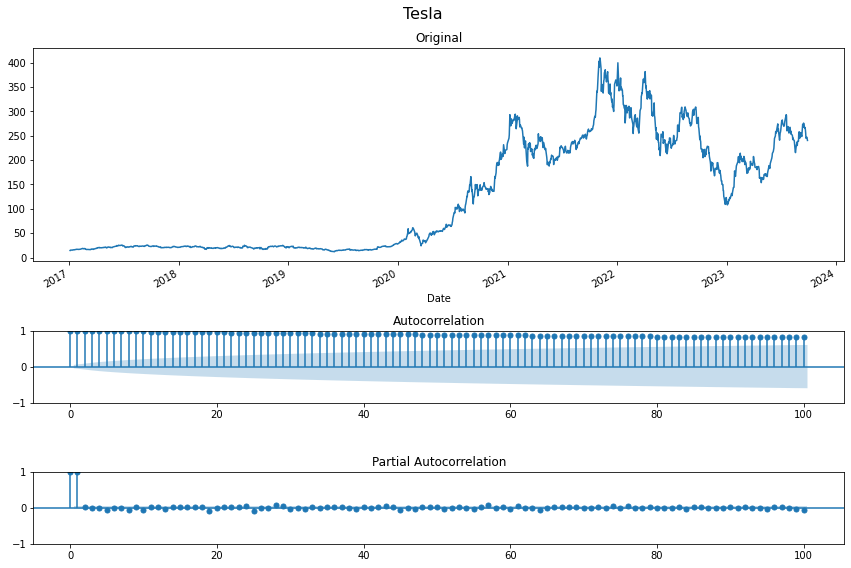

In [13]:
tsplot(df_tesla, 'Tesla', 'Original')

Results of Dickey-Fuller Test (Apple):
Test Statistic                   -0.702156
p-value                           0.846190
#Lags Used                       18.000000
Number of Observations Used    1676.000000
Critical Value (1%)              -3.434258
Critical Value (5%)              -2.863266
Critical Value (10%)             -2.567689
dtype: float64


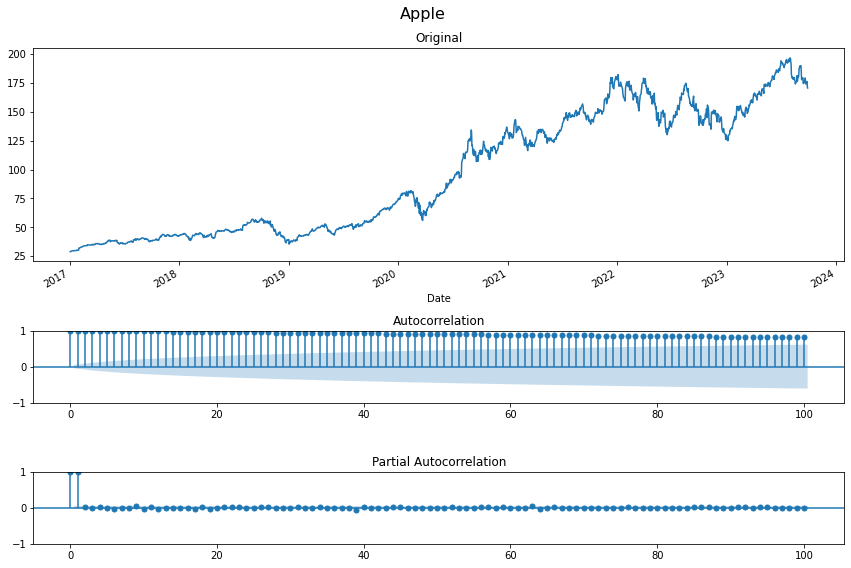

In [14]:
tsplot(df_apple, 'Apple', 'Original')

P-value (Tesla and Apple) is greater than 0.05. We cannot reject the null hypothesis (H(0): time series is not stationary).

Let's try BoxCox-Transormation:

#### BoxCox-Transformation:

Results of Dickey-Fuller Test (Tesla):
Test Statistic                   -0.863469
p-value                           0.799765
#Lags Used                        0.000000
Number of Observations Used    1694.000000
Critical Value (1%)              -3.434216
Critical Value (5%)              -2.863248
Critical Value (10%)             -2.567679
dtype: float64


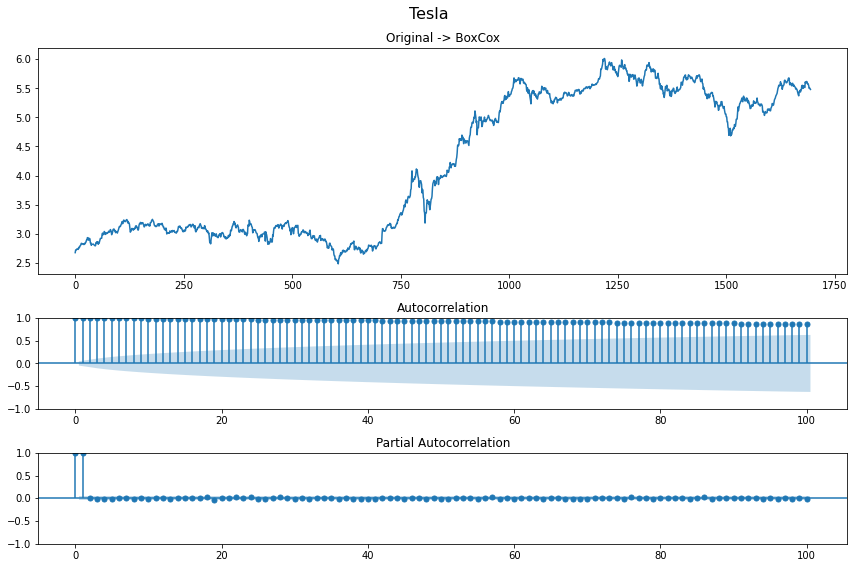

In [15]:
modified_tesla = boxcox(df_tesla, 0)
tsplot(modified_tesla, 'Tesla', 'Original -> BoxCox')

Results of Dickey-Fuller Test (Apple):
Test Statistic                   -1.209220
p-value                           0.669617
#Lags Used                        9.000000
Number of Observations Used    1685.000000
Critical Value (1%)              -3.434237
Critical Value (5%)              -2.863257
Critical Value (10%)             -2.567684
dtype: float64


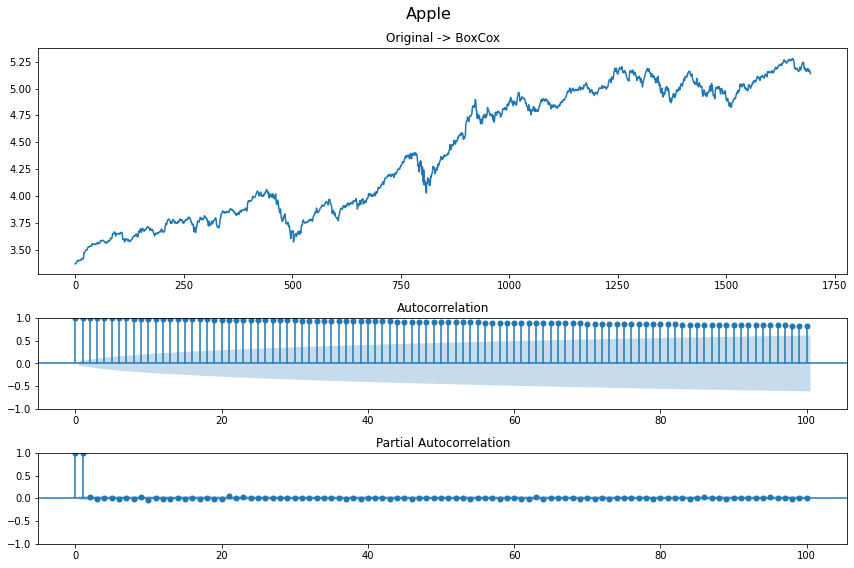

In [16]:
modified_apple = boxcox(df_apple, 0)
tsplot(modified_apple, 'Apple', 'Original -> BoxCox')

We have significantly reduced variance, but P-value (Tesla and Apple) is still greater than 0.05. We cannot reject the null hypothesis (H(0): time series is not stationary).

Let's try differentiating for deleting trend-component:

#### Differentiating:

Results of Dickey-Fuller Test (Tesla):
Test Statistic                  -28.202902
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1692.000000
Critical Value (1%)              -3.434221
Critical Value (5%)              -2.863250
Critical Value (10%)             -2.567680
dtype: float64


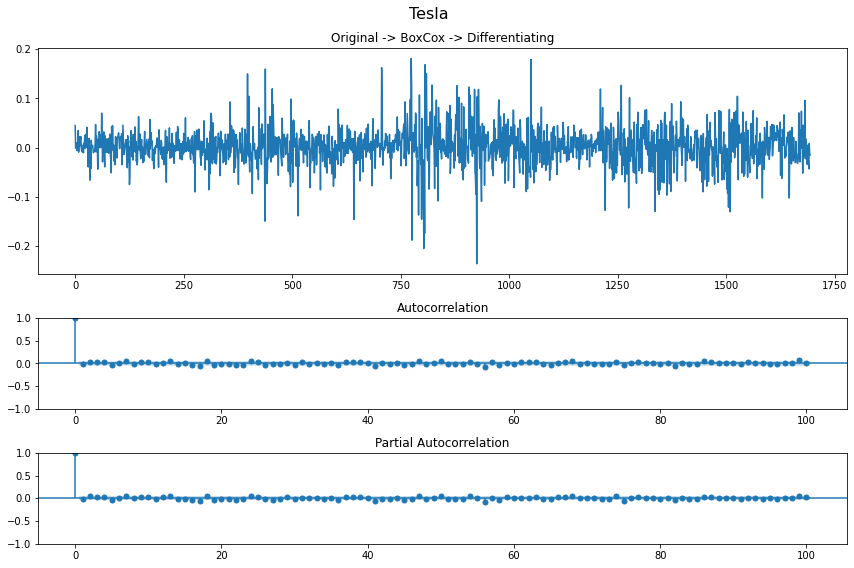

In [17]:
modified_tesla = modified_tesla[1:] - modified_tesla[:-1]
tsplot(modified_tesla, 'Tesla', 'Original -> BoxCox -> Differentiating')

Results of Dickey-Fuller Test (Apple):
Test Statistic                -1.287319e+01
p-value                        4.830345e-24
#Lags Used                     8.000000e+00
Number of Observations Used    1.685000e+03
Critical Value (1%)           -3.434237e+00
Critical Value (5%)           -2.863257e+00
Critical Value (10%)          -2.567684e+00
dtype: float64


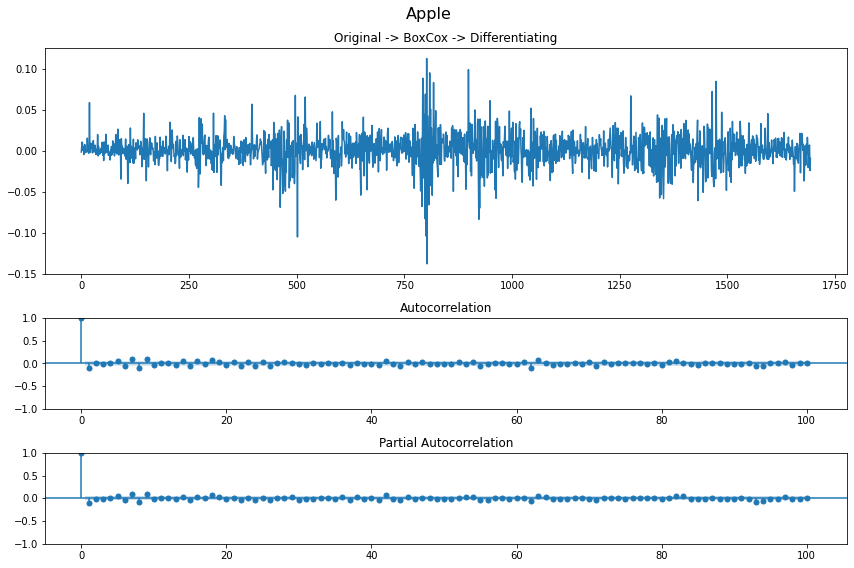

In [18]:
modified_apple = modified_apple[1:] - modified_apple[:-1]
tsplot(modified_apple, 'Apple', 'Original -> BoxCox -> Differentiating')

P-value (Tesla and Apple) is less than 0.05 -> we can reject H(0) -> time series (Tesla and Apple) are sationary.

### Summary:

- Decomposed the series into components: (trend, seasonality, residual)
- Transformated time series to stationarity:
  - Reduced variance using BoxCox
  - Got rid of autocorrelation and trend using Differentiating
  - Got P-value less then 0.05

# Exercise 2:
- Using the example of one of the companies, make a forecast for the next:
    -  month
    -  quarter
    -  half year
    -  year
- Indicate the rationale for the chosen model
- Assess the quality of the forecast according to the selected metric, check the quality on a test data.

## Prophet

We will use Prophet, because we don't need to transform the data series to a stationary series, unlike ARIMA for example.
Also, the library is quite convenient and gives forecasts no worse.

In [32]:
# preparation df fo Prophet
def get_prophet_df(path):
    df = pd.read_csv(path, parse_dates=['Date'])
    df = df[['Date', 'Close/Last']]
    df = df.set_axis(['ds', 'y'], axis=1)
    df['y'] = df['y'].apply(lambda x: x.replace('$', ''))
    df['y'] = df['y'].astype(float)
    df.sort_values(by=['ds'], inplace=True)
    df = df[df['ds'] > '2017-01-01']
    df.reset_index(inplace=True, drop=True)
    return df

In [33]:
df_tesla_pt = get_prophet_df('./tesla.csv')

In [45]:
# create train and test data
train_data, test_data = train_test_split(df_tesla_pt, test_size=0.1, shuffle=False)

In [46]:
# initialize and the model and train  
model = Prophet()
model.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [47]:
# predict yhat and calculate error
future_pred = model.make_future_dataframe(periods=len(test_data))
prediction = model.predict(future_pred)

In [48]:
print(f"MAE: {mean_absolute_error(test_data['y'], prediction['yhat'].tail(len(test_data)))}")

MAE: 67.66219058413739


<function matplotlib.pyplot.show(close=None, block=None)>

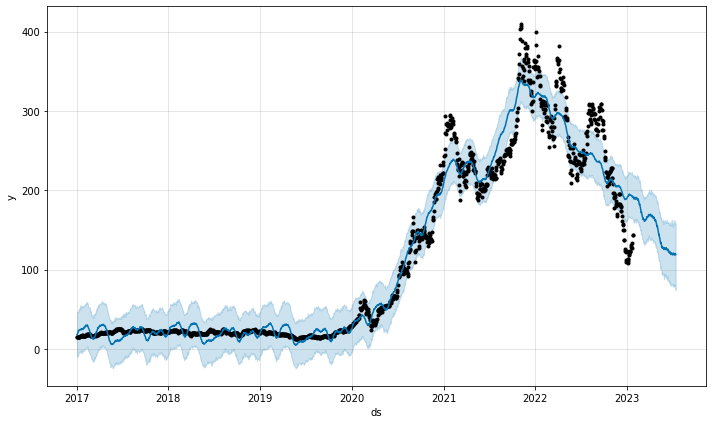

In [49]:
fig = model.plot(prediction)
#plt.plot(df_tesla_pt['ds'], df_tesla_pt['y'], 'r')
plt.show

In [50]:
# train on all data 
m = Prophet()
m.fit(df_tesla_pt)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [51]:
def show_forecast(period):
    future_pred = m.make_future_dataframe(periods=period)
    prediction = m.predict(future_pred)
    fig = m.plot(prediction)
    plt.title(f'{period} day(s) Tesla forecast')

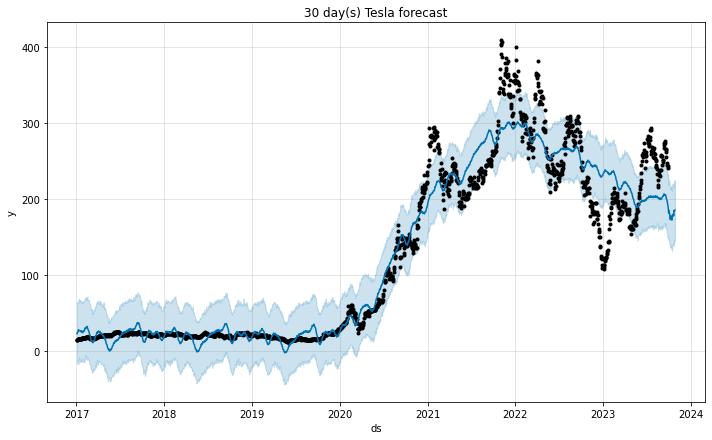

In [52]:
# month forecast
show_forecast(30)

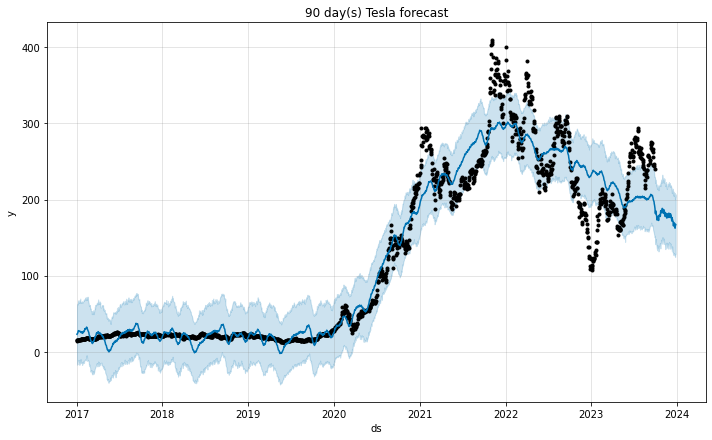

In [53]:
# quarter forecast
show_forecast(90)

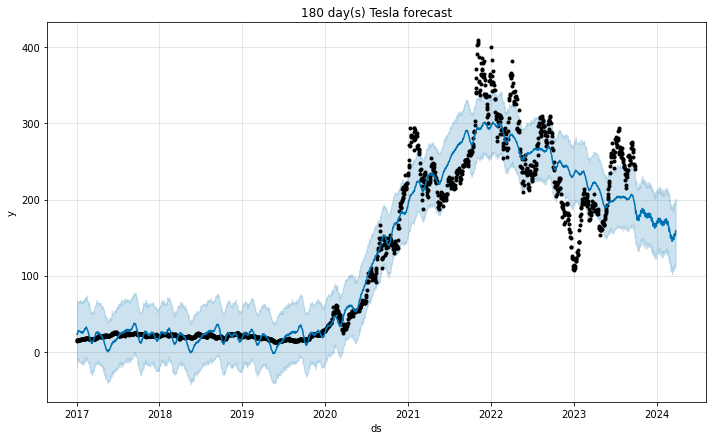

In [54]:
# half-year forecast
show_forecast(180)

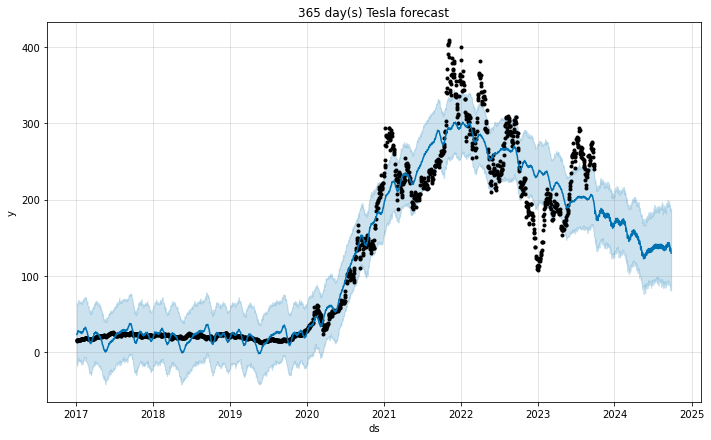

In [55]:
# year forecast
show_forecast(365)

## Summary

We received MAE = 67.66 for test data. We can get better results if we select the necessary parameters (seasonality, changepoints, seasonality_mode and etc.)